In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint

In [4]:
from helper.object_detection_helper import *
from loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from models.RetinaNet import RetinaNet

In [5]:
path = Path('/data/Datasets/EIPH_WSI/')

database = Database()
database.open(str(path/'EIPH.sqlite'))

True

In [6]:
class SlideContainer():

    def __init__(self, file: Path, level: int=0, width: int=256, height: int=256):
        self.file = file
        self.slide = openslide.open_slide(str(file))
        self.width = width
        self.height = height
        self.down_factor = slide.level_downsamples[level]

        if level is None:
            level = slide.level_count - 1
        self.level = level

    def get_patch(self,  x: int=0, y: int=0):
        return np.array(self.slide.read_region(location=(int(x * down_factor),int(y * down_factor)),
                                          level=self.level, size=(self.width, self.height)))[:, :, :3]

    @property
    def shape(self):
        return (self.width, self.height)

    def __str__(self):
        return str(self.path)

In [7]:
files = []
lbl_bbox = []

getslides = """SELECT uid, filename FROM Slides"""
for currslide, filename in tqdm(database.execute(getslides).fetchall()):
    database.loadIntoMemory(currslide)

    check = True if 'erliner' in filename else False
    slidetype = 'Berliner Blau/' if check else 'Turnbull Blue/'

    slide_path = path / slidetype / filename

    slide = openslide.open_slide(str(slide_path))
    level = 1#slide.level_count - 1
    level_dimension = slide.level_dimensions[level]
    down_factor = slide.level_downsamples[level]

    classes = {3: 1, 4: 2, 5: 3, 6: 4, 7: 5}
    labels, bboxes = [], []
    for id, annotation in database.annotations.items():
        if annotation.labels[0].classId in classes:
            d = 2 * annotation.r / down_factor
            x_min = (annotation.x1 - annotation.r) / down_factor
            y_min = (annotation.y1 - annotation.r) / down_factor
            x_max = x_min + d
            y_max = y_min + d
            label = classes[annotation.labels[0].classId]

            bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
            labels.append(label)

    if len(bboxes) > 0:
        lbl_bbox.append([bboxes, labels])
        files.append(SlideContainer(slide_path, level))

  0%|          | 0/24 [00:00<?, ?it/s]

Loading DB into memory ...


  4%|▍         | 1/24 [00:00<00:07,  3.21it/s]

Loading DB into memory ...


  8%|▊         | 2/24 [00:01<00:18,  1.19it/s]

Loading DB into memory ...


 12%|█▎        | 3/24 [00:02<00:15,  1.37it/s]

Loading DB into memory ...


 17%|█▋        | 4/24 [00:02<00:12,  1.55it/s]

Loading DB into memory ...


 21%|██        | 5/24 [00:02<00:10,  1.79it/s]

Loading DB into memory ...
Loading DB into memory ...


 33%|███▎      | 8/24 [00:03<00:06,  2.32it/s]

Loading DB into memory ...


 38%|███▊      | 9/24 [00:03<00:06,  2.48it/s]

Loading DB into memory ...
Loading DB into memory ...


 46%|████▌     | 11/24 [00:03<00:04,  2.88it/s]

Loading DB into memory ...
Loading DB into memory ...


 62%|██████▎   | 15/24 [00:04<00:02,  3.49it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 71%|███████   | 17/24 [00:05<00:02,  3.39it/s]

Loading DB into memory ...
Loading DB into memory ...


 79%|███████▉  | 19/24 [00:05<00:01,  3.66it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 88%|████████▊ | 21/24 [00:05<00:00,  3.61it/s]

Loading DB into memory ...
Loading DB into memory ...


100%|██████████| 24/24 [00:06<00:00,  3.51it/s]

Loading DB into memory ...


In [8]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

In [9]:
def bb_pad_collate(samples:BatchSamples, pad_idx:int=0) -> Tuple[FloatTensor, Tuple[LongTensor, LongTensor]]:
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    samples = [s for s in samples if s[1].data[0].shape[0] > 0] # check that labels are available

    max_len = max([len(s[1].data[1]) for s in samples])
    bboxes = torch.zeros(len(samples), max_len, 4)
    labels = torch.zeros(len(samples), max_len).long() + pad_idx
    imgs = []
    for i,s in enumerate(samples):
        imgs.append(s[0].data[None])
        bbs, lbls = s[1].data
        bboxes[i,-len(lbls):] = bbs
        labels[i,-len(lbls):] = torch.from_numpy(lbls)
    return torch.cat(imgs,0), (bboxes,labels)

In [10]:
class SlideLabelList(LabelList):

    def __getitem__(self,idxs:Union[int,np.ndarray])->'LabelList':
        idxs = try_int(idxs)
        if isinstance(idxs, numbers.Integral):
            if self.item is None:
                h, w = self.x.items[idxs].shape
                class_id = np.random.choice(list(set(self.y.items[idxs][1])), 1)[0]
                ids = self.y.items[idxs][1] == class_id
                xmin, ymin, xmax, ymax = np.array(self.y.items[idxs][0])[ids][randint(0, np.count_nonzero(ids) - 1)]
                x = self.x.get(idxs, int(xmin - w / 2), int(ymin - h / 2))
                y = self.y.get(idxs, int(xmin - w / 2), int(ymin - h / 2))
            else:
                x,y = self.item ,0
            if self.tfms or self.tfmargs:
                x = x.apply_tfms(self.tfms, **self.tfmargs)
            if hasattr(self, 'tfms_y') and self.tfm_y and self.item is None:
                y = y.apply_tfms(self.tfms_y, **{**self.tfmargs_y, 'do_resolve':False})
            if y is None: y=0
            return x,y
        else:
            return self.new(self.x[idxs], self.y[idxs])

In [11]:
class SlideItemList(ItemList):

    def __getitem__(self,idxs: int, x: int=0, y: int=0)->Any:
        idxs = try_int(idxs)
        if isinstance(idxs, numbers.Integral):
            return self.get(idxs, x, y)
        else:
            return self.get(*idxs)

    def label_from_list(self, labels:Iterator, label_cls:Callable=None, **kwargs)->'LabelList':
        "Label `self.items` with `labels`."
        labels = array(labels, dtype=object)
        label_cls = self.get_label_cls(labels, label_cls=label_cls, **kwargs)
        y = label_cls(labels, path=self.path, **kwargs)
        res = SlideLabelList(x=self, y=y)
        return res

In [12]:
class SlideImageItemList(SlideItemList):
    pass

class SlideObjectItemList(SlideImageItemList, ImageItemList):

    def get(self, i, x: int, y: int):
        fn = self.items[i]
        res = self.open(fn, x, y)
        self.sizes[i] = res.size
        return res

class ObjectItemListSlide(SlideObjectItemList):

    def open(self, fn: SlideContainer,  x: int=0, y: int=0):
        return Image(pil2tensor(fn.get_patch(x, y) / 255., np.float32))


class SlideObjectCategoryList(ObjectCategoryList):

    def get(self, i, x: int=0, y: int=0):
        h, w = self.x.items[i].shape
        bboxes, labels = self.items[i]
        if x > 0 and y > 0:
            bboxes = np.array(bboxes)
            labels = np.array(labels)
            ids = (bboxes[:, 0] > x) & (bboxes[:, 2] < x + w) & (bboxes[:, 1] > y) & (bboxes[:, 3] < y + h)
            bboxes = [[box[1] - y,box[0] - x, box[3] - y,  box[2] - x] for box in bboxes[ids]]
            labels = labels[ids] # list(labels)
        return ImageBBox.create(h, w, bboxes, labels, classes=self.classes, pad_idx=self.pad_idx)

In [13]:
bs = 32
train_images = 5000
val_images = 500

train_files = list(np.random.choice(files[4:], train_images))
valid_files = list(np.random.choice(files[:4], val_images))

In [43]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90, 90)}, p=0.5, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [44]:
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=256)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate)

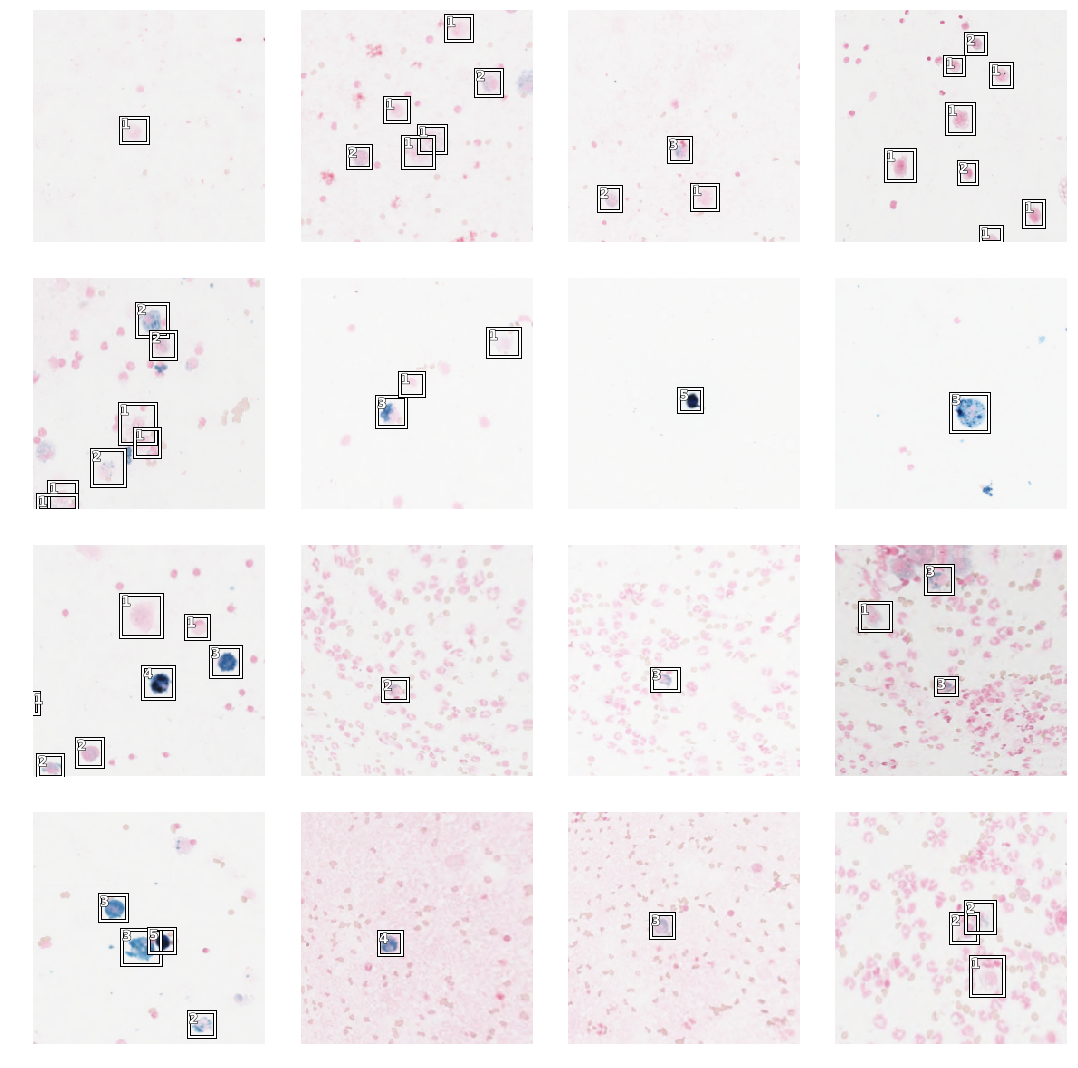

In [15]:
data.show_batch(rows=4, ds_type=DatasetType.Train, figsize=(15,15))

In [54]:
anchors_32 = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.5, 0.7, 1])

In [55]:
anchors = anchors_32

In [18]:
anchors_16 = create_anchors(sizes=[(16,16)], ratios=[1], scales=[0.5, 0.7, 1])

In [19]:
anchors = torch.cat((anchors_32, anchors_16), 0)

In [20]:
anchors.shape

torch.Size([3840, 4])

In [56]:
anchors

tensor([[-0.9688, -0.9688,  0.1250,  0.1250],
        [-0.9688, -0.9688,  0.1750,  0.1750],
        [-0.9688, -0.9688,  0.2500,  0.2500],
        ...,
        [ 0.9688,  0.9688,  0.1250,  0.1250],
        [ 0.9688,  0.9688,  0.1750,  0.1750],
        [ 0.9688,  0.9688,  0.2500,  0.2500]])

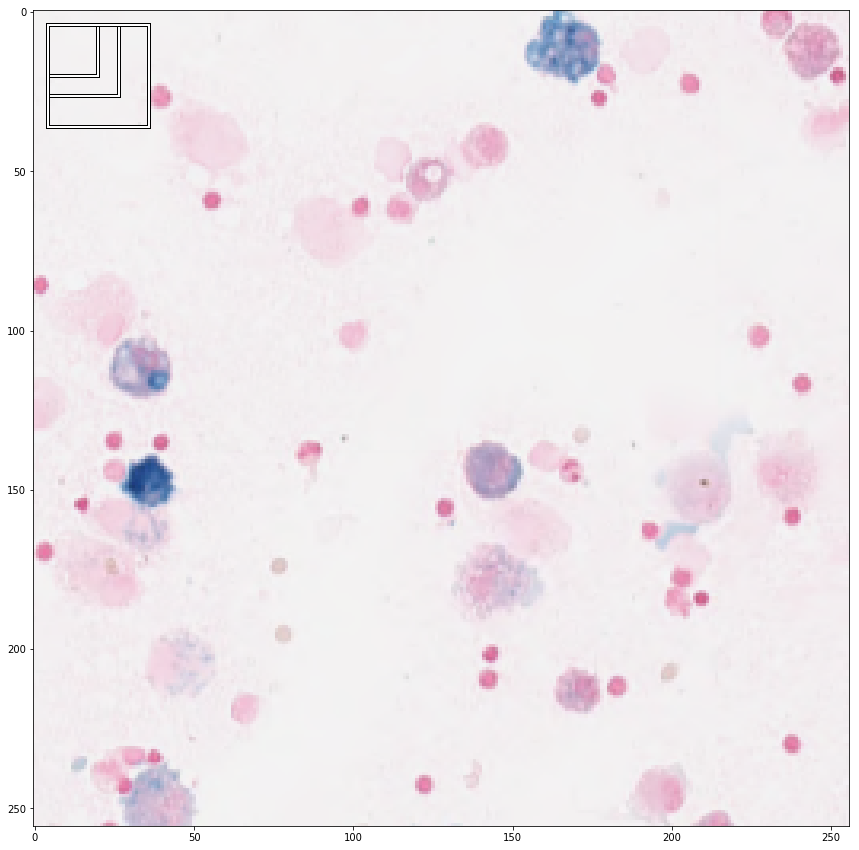

In [58]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:3]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * 256 / 2 
    y = (bb[1] + 1) * 256 / 2 
    w = bb[2] * 256 / 2
    h = bb[3] * 256 / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [23]:
class LossMetrics(LearnerCallback):
    "Add `loss_func.metrics` to metrics named by `loss_func.metric_names`"
    _order = -20 #Needs to run before the recorder

    def on_train_begin(self, **kwargs):
        "Add the metrics names to the `Recorder`."
        self.names = ifnone(self.learn.loss_func.metric_names, [])
        if not self.names: warn('LossMetrics requested by no loss_func.metric_names provided')
        self.learn.recorder.add_metric_names(self.names)

    def on_epoch_begin(self, **kwargs):
        "Initialize the metrics for this epoch."
        self.metrics = {name:0. for name in self.names}
        self.nums = 0

    def on_batch_end(self, last_target, train, **kwargs):
        "Update the metrics if not `train`"
        if train: return
        bs = last_target[0].size(0)
        for name in self.names:
            self.metrics[name] += bs * self.learn.loss_func.metrics[name].detach().cpu()
        self.nums += bs

    def on_epoch_end(self, **kwargs):
        "Finish the computation and sends the result to the Recorder."
        if not self.nums: return
        metrics = [self.metrics[name]/self.nums for name in self.names]
        self.learn.recorder.add_metrics(metrics)

In [31]:
crit = RetinaNetFocalLoss(anchors)

In [45]:
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[32], chs=32, final_bias=-4., n_conv=2)

In [46]:
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, LossMetrics])

In [47]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


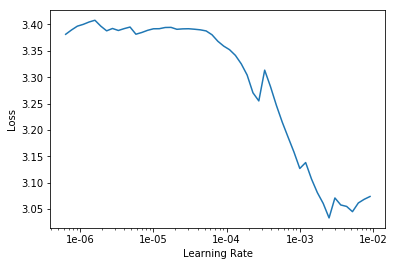

In [35]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,BBloss,focal_loss
1,1.448174,0.973632,0.276550,0.697082
2,0.942564,0.750675,0.232017,0.518658
3,0.815552,0.687872,0.208987,0.478885


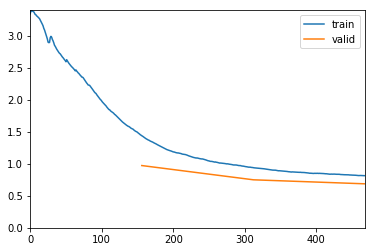

In [48]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,BBloss,focal_loss
1,0.717871,0.648926,0.191465,0.457462
2,0.606012,0.594922,0.221103,0.373819
3,0.578274,0.552375,0.174709,0.377665
4,0.520459,0.702514,0.221322,0.481192
5,0.552909,0.464736,0.167457,0.297280
6,0.468757,0.449972,0.147325,0.302647
7,0.433086,0.389696,0.131122,0.258574
8,0.408578,0.577120,0.263898,0.313222
9,0.384879,0.382794,0.136358,0.246436
10,0.374334,0.370853,0.129222,0.241631


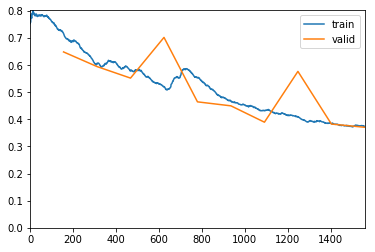

In [49]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,BBloss,focal_loss
1,0.383587,0.634885,0.260629,0.374257
2,0.415638,0.922732,0.408973,0.513759
3,0.475274,1.402983,0.238876,1.164107
4,0.440958,0.673795,0.181703,0.492093
5,0.418142,0.788961,0.291166,0.497796
6,0.382605,0.406830,0.140963,0.265868
7,0.366287,0.698195,0.245403,0.452792
8,0.336438,0.503944,0.209187,0.294757
9,0.320504,0.380988,0.133103,0.247886
10,0.316951,0.323702,0.099627,0.224075


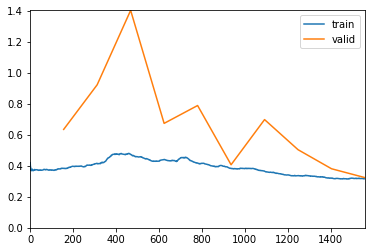

In [50]:
learn.fit_one_cycle(10, 1e-3)

In [38]:
classes = data.train_ds.classes

In [39]:
classes

['background', 1, 2, 3, 4, 5]

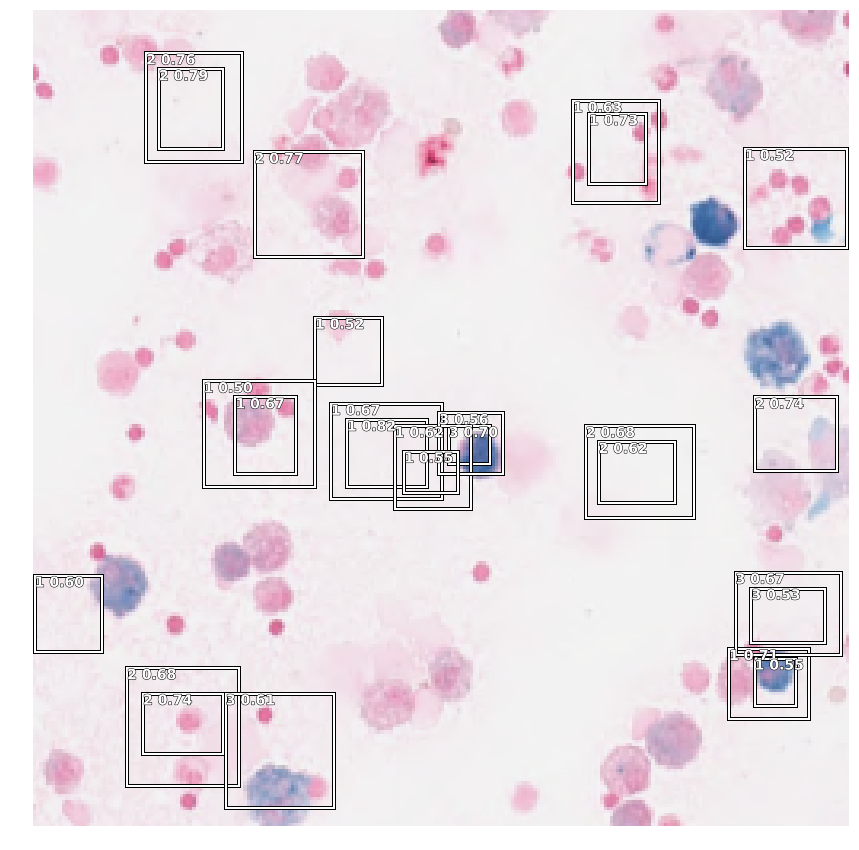

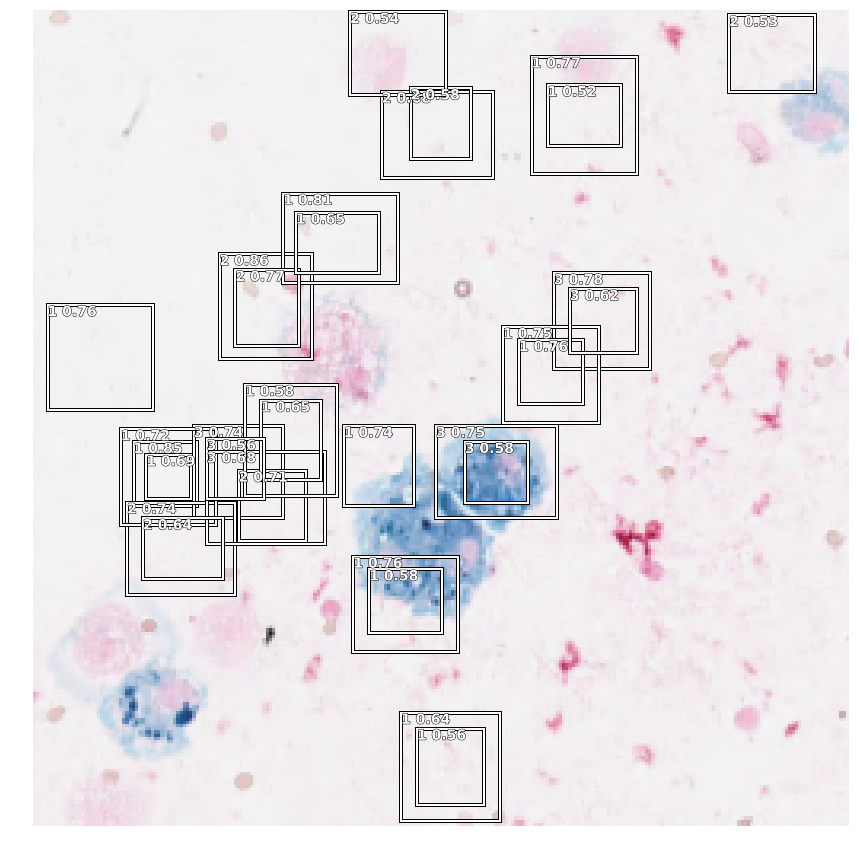

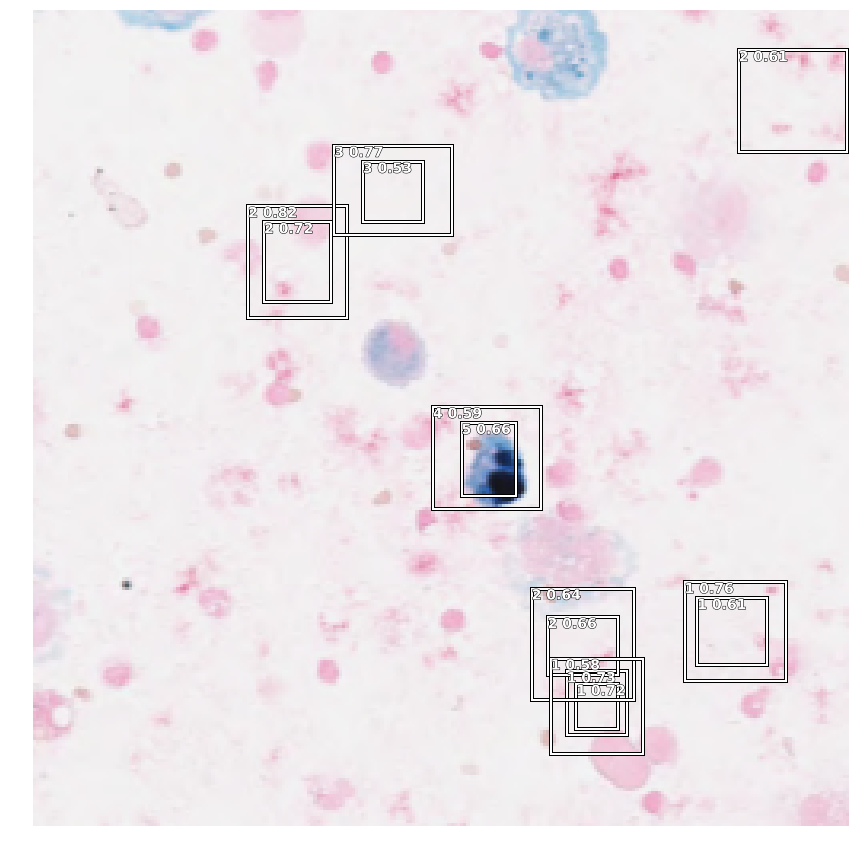

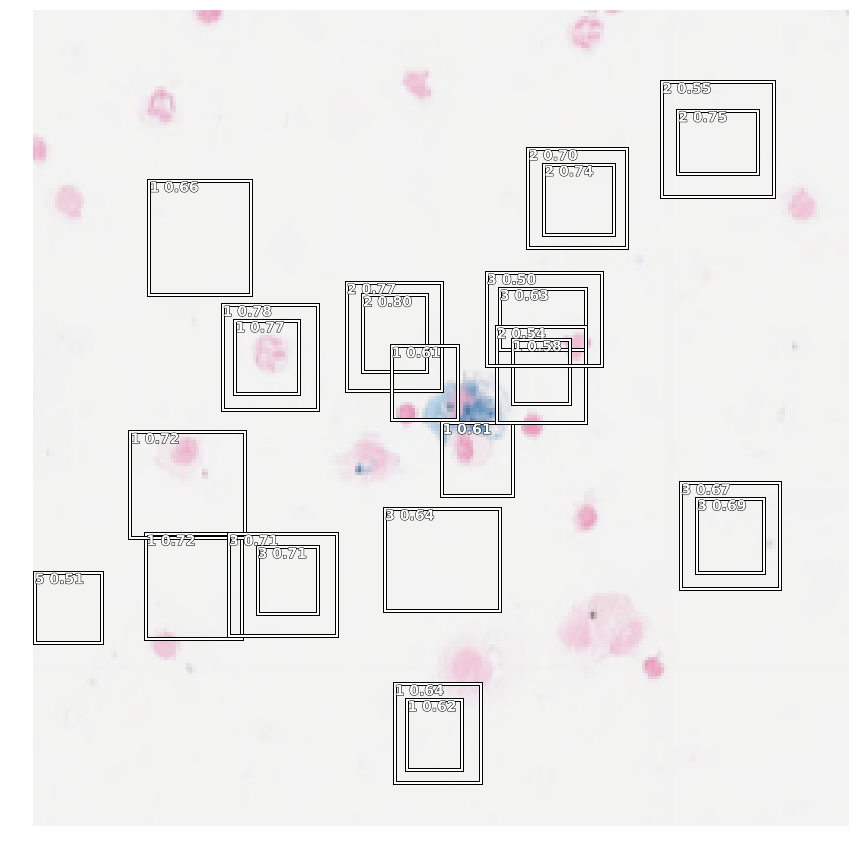

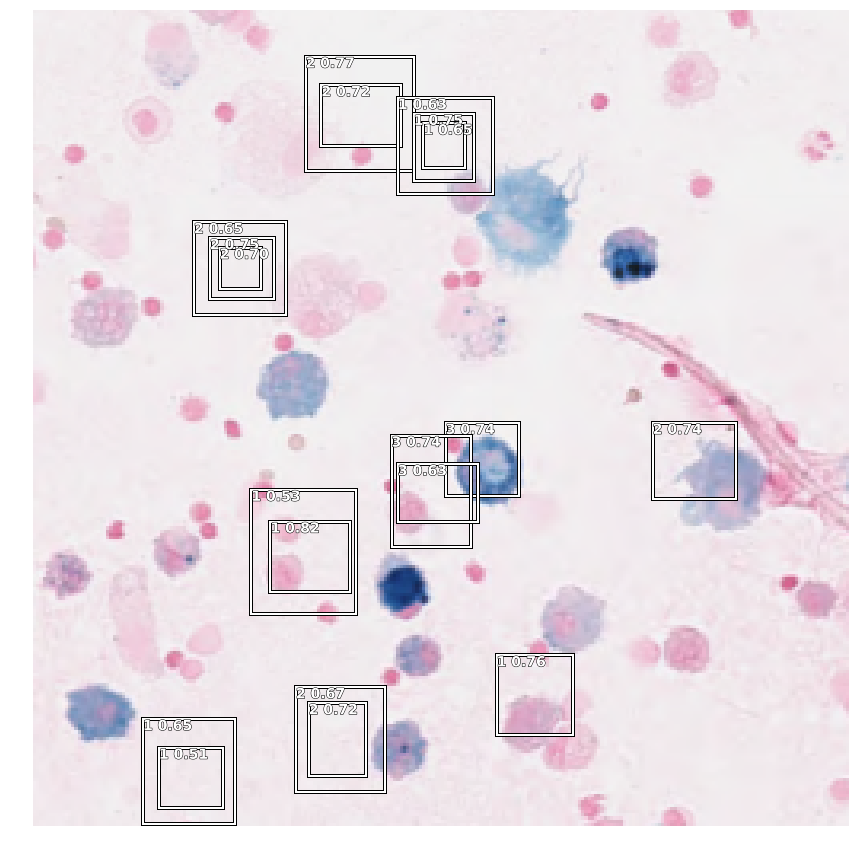

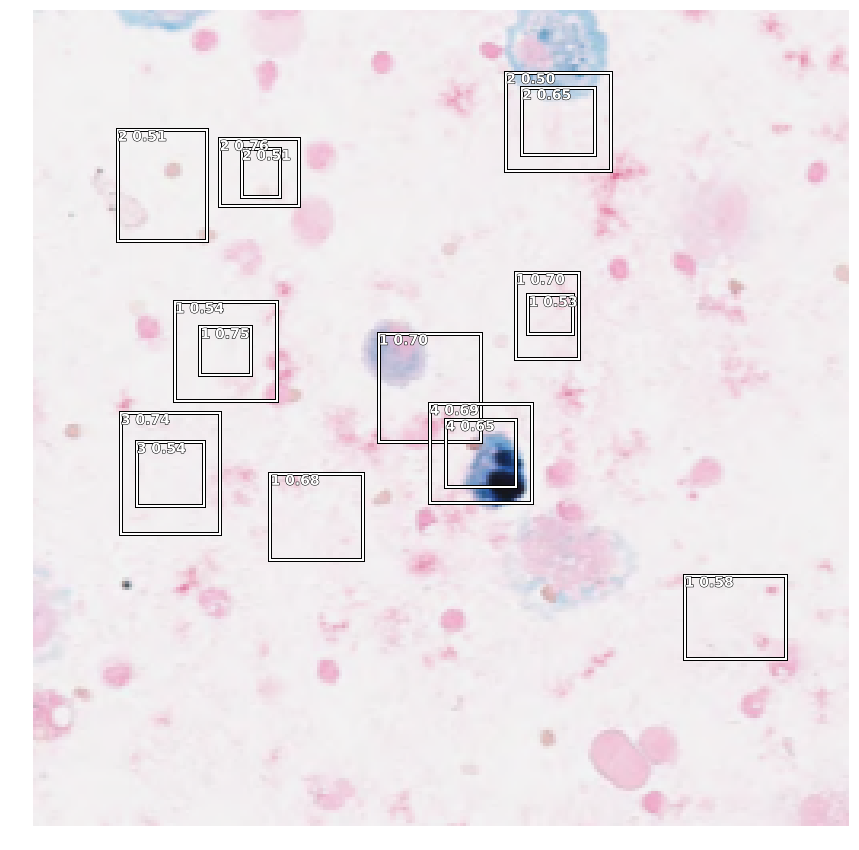

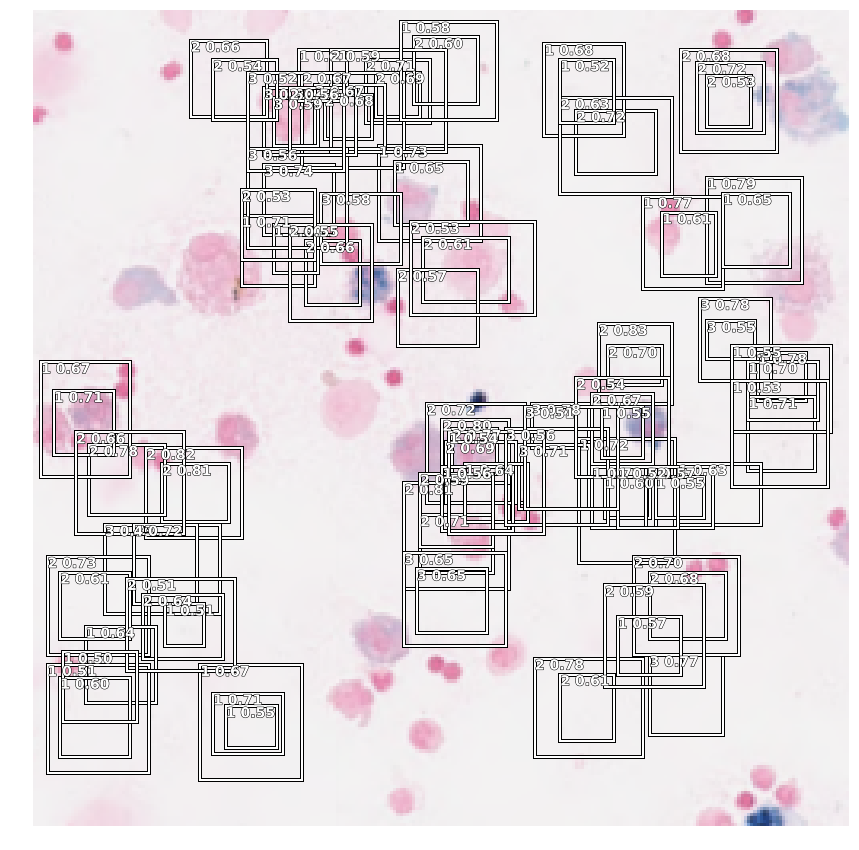

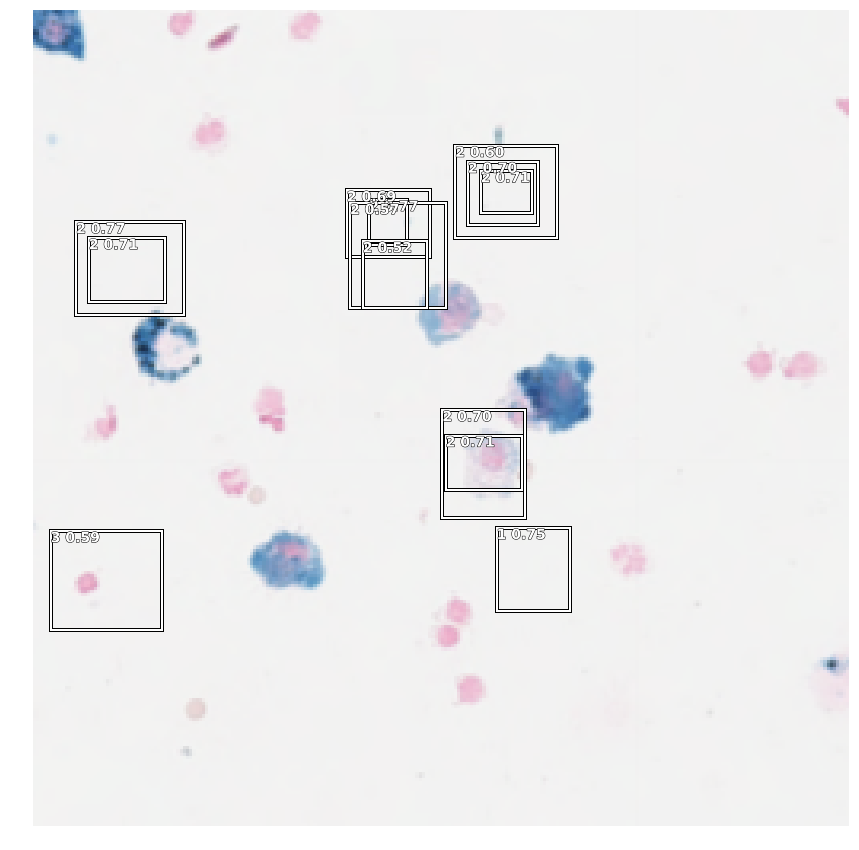

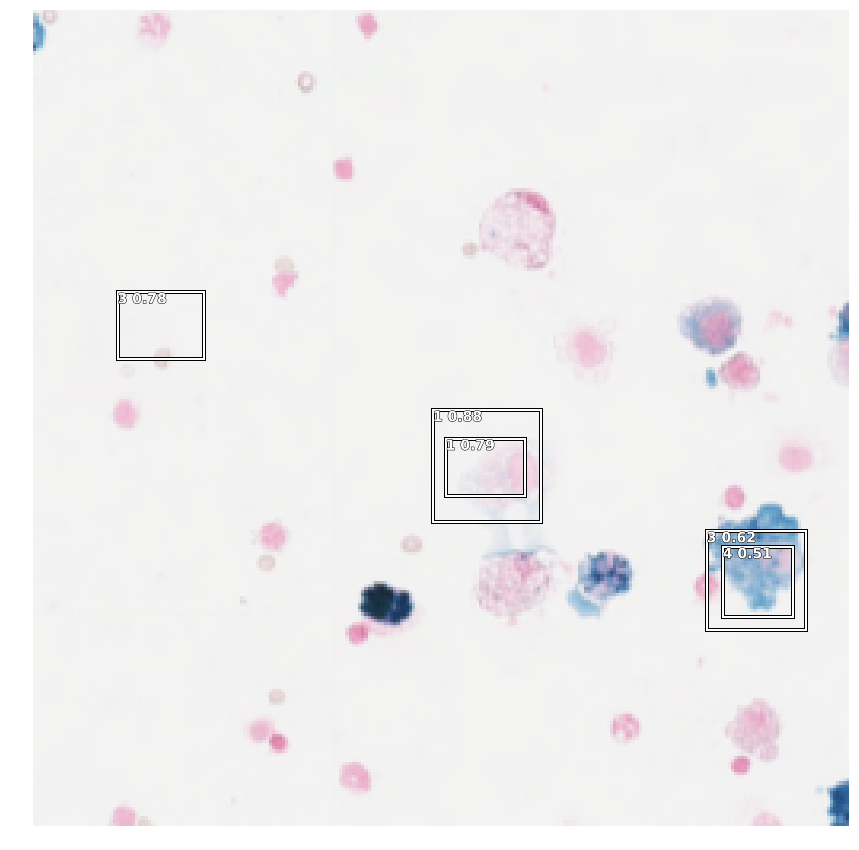

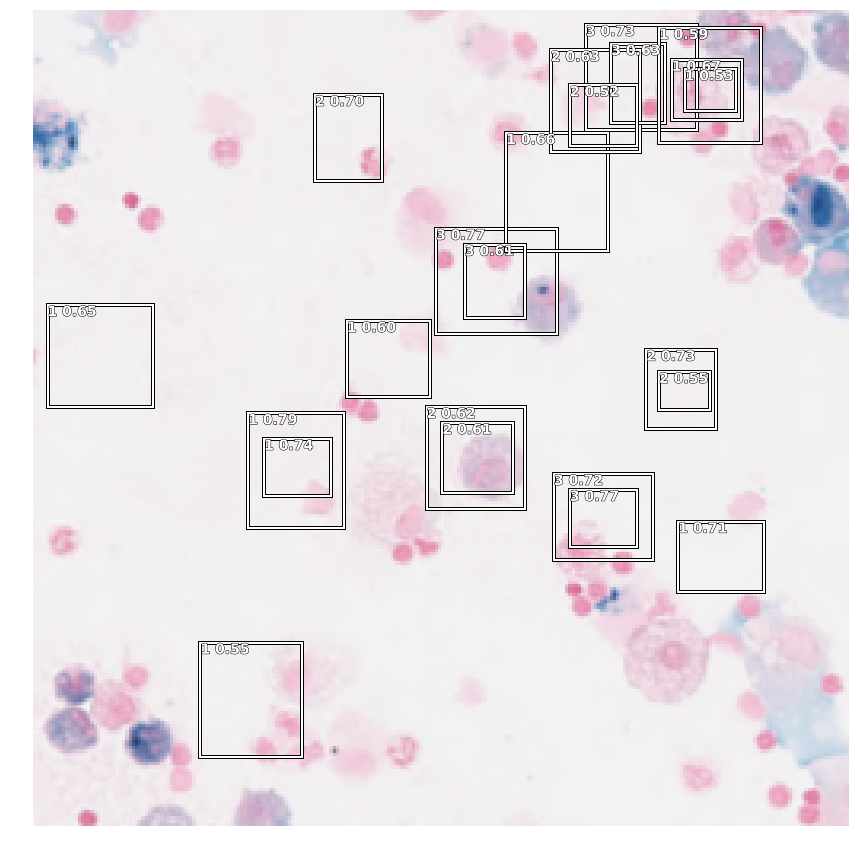

In [51]:
img_batch,target = next(iter(data.valid_dl))
with torch.no_grad():
    output = model(img_batch[:10])
    for idx in range(len(output[0])):
        img = data.valid_ds[idx][0] 
        clas_pred = output[0][idx]
        bbox_pred = output[1][idx]

        bbox_pred, scores, preds = process_output(clas_pred, bbox_pred, anchors, 0.5)
        if bbox_pred is None:
            continue
            
        to_keep = nms(bbox_pred, scores, 0.5)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()

        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:, :2] = bbox_pred[:, :2] - bbox_pred[:, 2:] / 2
        bbox_pred[:, :2] = (bbox_pred[:, :2] + 1) * t_sz / 2
        bbox_pred[:, 2:] = bbox_pred[:, 2:] * t_sz / 2
        bbox_pred = bbox_pred.long()

        show_preds(img, bbox_pred, preds, scores, classes, (15,15))